# Entrenamiento de Modelos de Machine Learning

Este notebook se centrará en transformar nuestros datos preprocesados en modelos predictivos y de clasificación robustos. Nuestro objetivo es entrenar y optimizar algoritmos que puedan predecir tendencias energéticas futuras, identificar países líderes en la transición y desentrañar las relaciones complejas entre variables energéticas.

## 1. Configuraciones del Entorno de Trabajo y Rutas

* Importación de Librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
import xgboost as xgb # Una excelente opción para regresión y clasificación
from prophet import Prophet # Para modelos de series temporales
from prophet.plot import add_changepoints_to_plot
import joblib # Para guardar y cargar modelos
import warnings

c:\Users\PC\Documents\Ingenieria\Semestre 6\Topicos Especiales\Machine_Learning\global_energy_ml_project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* Importación de Funciones Personalizadas

In [2]:
import sys
import os
sys.path.append(os.path.abspath('..'))
import src.modelado as mod
import src.visualizacion as vis
import src.preprocesamiento as pre

* Configuración Global

In [3]:
# Para suprimir advertencias
warnings.filterwarnings("ignore")

# Configuración de Pandas para una mejor visualización de DataFrames
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('display.max_rows', 50)

# Configuración de NumPy para una salida más limpia
np.set_printoptions(precision=2, suppress=True)

# Configuración de Matplotlib
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12


# Configuración de Seaborn
sns.set_style('whitegrid')
sns.set_palette('deep')

# Configuración de Scikit-learn

tscv = TimeSeriesSplit(n_splits=5)
rf_params = {'n_estimators': [100, 200], 'max_depth': [10, 20, None]}
xgb_params = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}

# Configuración de Prophet
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)

* Rutas

In [4]:
raw_path = os.path.join('..', 'data', 'original', 'global_energy_consumption.csv')
data_path = os.path.join('..', 'data', 'procesados', 'global_energy_consumption_features.csv')

* Carga del Dataset Limpio y Procesado

In [5]:
df = pre.cargar_datos(data_path)
df_raw = pre.cargar_datos(raw_path)

## 2. Segmentación del Dataset para Modelos de Series Temporales, Regresión y Clasificación

### 2.1. Problema 1: Predicción de Series Temporales

Utilizaremos Prophet para estas predicciones, ya que es robusto para datos con estacionalidad y tendencias.

* Preparación para Prophet (Series Temporales) generando los DataFrames.

In [6]:
df_prophet_total = mod.mensualizar_datos(df, columna_valor='Total Energy Consumption (TWh)')
df_prophet_percapita = mod.mensualizar_datos(df, columna_valor='Per Capita Energy Use (kWh)')

### 2.2. Problema 2: Regresión

Aquí prepararemos los datos para predecir variables numéricas como `Carbon Emissions`.

* Ordenando el DataFrame

In [7]:
df = df.sort_values(by=['Country', 'Year'])

* Selección de características (quitando las columnas que son de interés para otros modelos)

In [8]:
caracteristicas_base = [col for col in df.columns if col not in [
    'Country', 'Year', 
    'Total Energy Consumption (TWh)', 'Per Capita Energy Use (kWh)',
    'Renewable Energy Share (%)']]

* Asegurar inclusión de columnas codificadas One-Hot de Country

In [9]:
country_one_hot_cols = [col for col in df.columns if col.startswith('Country_')]


* Crear el conjunto final de características (`caracteristicas_regresion`)

In [10]:
caracteristicas_regresion = [col for col in caracteristicas_base if col not in country_one_hot_cols] + country_one_hot_cols
caracteristicas_regresion

['Fossil Fuel Dependency (%)',
 'Carbon Emissions (Million Tons)',
 'Energy Price Index (USD/kWh)',
 'Industrial Energy Use (%)',
 'Household Energy Use (%)',
 'Tasa Anual Total Energy Consumption (TWh)',
 'Tasa Anual Per Capita Energy Use (kWh)',
 'Tasa Anual Carbon Emissions (Million Tons)',
 'renewable_fossil_ratio',
 'energy_efficiency',
 'fossil_total_ratio',
 'price_emissions_ratio',
 'Country_Australia',
 'Country_Brazil',
 'Country_Canada',
 'Country_China',
 'Country_Germany',
 'Country_India',
 'Country_Japan',
 'Country_Russia',
 'Country_UK',
 'Country_USA']

* Definir la variable objetivo

In [11]:
variable_objetivo = 'Carbon Emissions (Million Tons)'

* Crear `X_reg` y `y_reg` (caracteristicas y variable objetivo)

    * `X_reg`: contiene todas las columnas seleccionadas como caracteristicas, sin incluir la variable objetivo.

    * `y_reg`: contiene solo la variable objetivo.

In [12]:
df_men = mod.remuestrear_datos_mensuales(df, caracteristicas_regresion)

In [13]:
X_reg = df_men[caracteristicas_regresion].drop(columns=[variable_objetivo], errors='ignore')
y_reg = df_men[variable_objetivo]


* Crear lags (o rezagos)

* Dividir los datos en entrenamiento y prueba (80% para entrenamiento y 20% para prueba)

In [14]:
train_size = int(0.8 * len(X_reg))
X_train_reg = X_reg.iloc[:train_size]
X_test_reg = X_reg.iloc[train_size:]
y_train_reg = y_reg.iloc[:train_size]
y_test_reg = y_reg.iloc[train_size:]

* Rangos de los dataset

In [15]:
for col in X_train_reg.columns[0:27+1]:
    minimo = X_train_reg[col].min()
    maximo = X_train_reg[col].max()
    print(f"Máximo/mínimo de {col}: {maximo} / {minimo}")

Máximo/mínimo de Fossil Fuel Dependency (%): 0.8388109536075724 / -0.9161903361773996
Máximo/mínimo de Energy Price Index (USD/kWh): 0.8910992302338926 / -0.9632227988024312
Máximo/mínimo de Industrial Energy Use (%): 1.082630210285962 / -1.0938396620885846
Máximo/mínimo de Household Energy Use (%): 0.8924126948690718 / -0.9343765992613181
Máximo/mínimo de Tasa Anual Total Energy Consumption (TWh): 7.5376066551744 / -0.39526652243193405
Máximo/mínimo de Tasa Anual Per Capita Energy Use (kWh): 6.858965950264462 / -0.35944694397815624
Máximo/mínimo de Tasa Anual Carbon Emissions (Million Tons): 7.447200367272249 / -0.3889733553240416
Máximo/mínimo de renewable_fossil_ratio: 1.7839935374636369 / -0.4865615727152848
Máximo/mínimo de energy_efficiency: 6.313823900258639 / -0.45469628670786993
Máximo/mínimo de fossil_total_ratio: 0.7806219996300198 / -0.5768371998726685
Máximo/mínimo de price_emissions_ratio: 7.62691219722787 / -0.3195634801379778
Máximo/mínimo de Country_Australia: 1.0 / 0.

* Verificando dimensiones

In [16]:
print(f"X_train_reg shape: {X_train_reg.shape}")
print(f"X_test_reg shape: {X_test_reg.shape}")
print(f"y_train_reg shape: {y_train_reg.shape}")
print(f"y_test_reg shape: {y_test_reg.shape}")

X_train_reg shape: (2400, 21)
X_test_reg shape: (600, 21)
y_train_reg shape: (2400,)
y_test_reg shape: (600,)


* Mostrar resultados

In [17]:
print(f"\nCaracterísticas de regresión (X_reg.columns): {X_reg.columns.tolist()}")
print(f"Variable objetivo de regresión (y_reg.name): {y_reg.name}")


Características de regresión (X_reg.columns): ['Fossil Fuel Dependency (%)', 'Energy Price Index (USD/kWh)', 'Industrial Energy Use (%)', 'Household Energy Use (%)', 'Tasa Anual Total Energy Consumption (TWh)', 'Tasa Anual Per Capita Energy Use (kWh)', 'Tasa Anual Carbon Emissions (Million Tons)', 'renewable_fossil_ratio', 'energy_efficiency', 'fossil_total_ratio', 'price_emissions_ratio', 'Country_Australia', 'Country_Brazil', 'Country_Canada', 'Country_China', 'Country_Germany', 'Country_India', 'Country_Japan', 'Country_Russia', 'Country_UK', 'Country_USA']
Variable objetivo de regresión (y_reg.name): Carbon Emissions (Million Tons)


### 2.3. Problema 3: Clasificación

Aquí crearemos una variable binaria y prepararemos los datos para clasificación.

* Crear la variable objetivo binaria

In [18]:
df['high_renewable_adoption'] = (df['Renewable Energy Share (%)'] > 0.5).astype(int)
df['high_renewable_adoption'].value_counts(normalize=True)

high_renewable_adoption
0   0.65
1   0.35
Name: proportion, dtype: float64

**Nota:** Es importante resaltar que para la nueva categoria `'high_renewable_adoption'` presenta una clase minoritaria dado que el 35% de los datos son mayores a 0.5, por lo que sera relevante para la selección del hiper-parámetro `'class_weight'`.

* Definir la variable objetivo para clasificación

In [19]:
variable_objetivo_clasificacion = 'high_renewable_adoption'

* Definir las características (X) para clasificación

In [20]:
caracteristicas_clasificacion = ['Fossil Fuel Dependency (%)', 'renewable_fossil_ratio', 'fossil_total_ratio',
                                 'Energy Price Index (USD/kWh)', 'Tasa Anual Total Energy Consumption (TWh)',
                                 'Tasa Anual Per Capita Energy Use (kWh)', 'Tasa Anual Carbon Emissions (Million Tons)'] + country_one_hot_cols

caracteristicas_clasificacion

['Fossil Fuel Dependency (%)',
 'renewable_fossil_ratio',
 'fossil_total_ratio',
 'Energy Price Index (USD/kWh)',
 'Tasa Anual Total Energy Consumption (TWh)',
 'Tasa Anual Per Capita Energy Use (kWh)',
 'Tasa Anual Carbon Emissions (Million Tons)',
 'Country_Australia',
 'Country_Brazil',
 'Country_Canada',
 'Country_China',
 'Country_Germany',
 'Country_India',
 'Country_Japan',
 'Country_Russia',
 'Country_UK',
 'Country_USA']

* Definir X (features) e y (target)

In [21]:
X_cls = df[caracteristicas_clasificacion].copy()
y_cls = df[variable_objetivo_clasificacion]


* División del dataset en entrenamiento y prueba (80% para entrenamiento y 20% para prueba)

In [22]:
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

* Mostrar resultados

In [23]:
print(f"\nCaracterísticas de clasificación (X_cls.columns): {X_cls.columns.tolist()}")
print(f"Variable objetivo de clasificación (y_cls.name): {y_cls.name}")
print(f"Dimensiones de X_train_cls: {X_train_cls.shape}")


Características de clasificación (X_cls.columns): ['Fossil Fuel Dependency (%)', 'renewable_fossil_ratio', 'fossil_total_ratio', 'Energy Price Index (USD/kWh)', 'Tasa Anual Total Energy Consumption (TWh)', 'Tasa Anual Per Capita Energy Use (kWh)', 'Tasa Anual Carbon Emissions (Million Tons)', 'Country_Australia', 'Country_Brazil', 'Country_Canada', 'Country_China', 'Country_Germany', 'Country_India', 'Country_Japan', 'Country_Russia', 'Country_UK', 'Country_USA']
Variable objetivo de clasificación (y_cls.name): high_renewable_adoption
Dimensiones de X_train_cls: (8000, 17)


## 3. Entrenamiento y Optimización de Modelos

Aquí entrenaremos modelos base y luego usaremos `GridSearchCV` para la optimización de hiperparámetros.

### 3.1. Modelo de Series Temporales: Prophet

* Crear un directorio para los modelos de Prophet

In [24]:
os.makedirs('../models/prophet_models', exist_ok=True)
os.makedirs('../outputs/prophet_forecasts', exist_ok=True)

* Inicializar diccionarios y definir horizonte de predicción

In [25]:
prophet_models = {} # Diccionario para almacenar los modelos de Prophet por país
predicciones = {}
forecast_horizon_years = 7 # Número de años a predecir

* Entrenando a Prophet para la variable `Consumo Total de Energía (TWh)`

Entrenando Prophet para Australia...


23:44:33 - cmdstanpy - INFO - Chain [1] start processing
23:44:33 - cmdstanpy - INFO - Chain [1] done processing


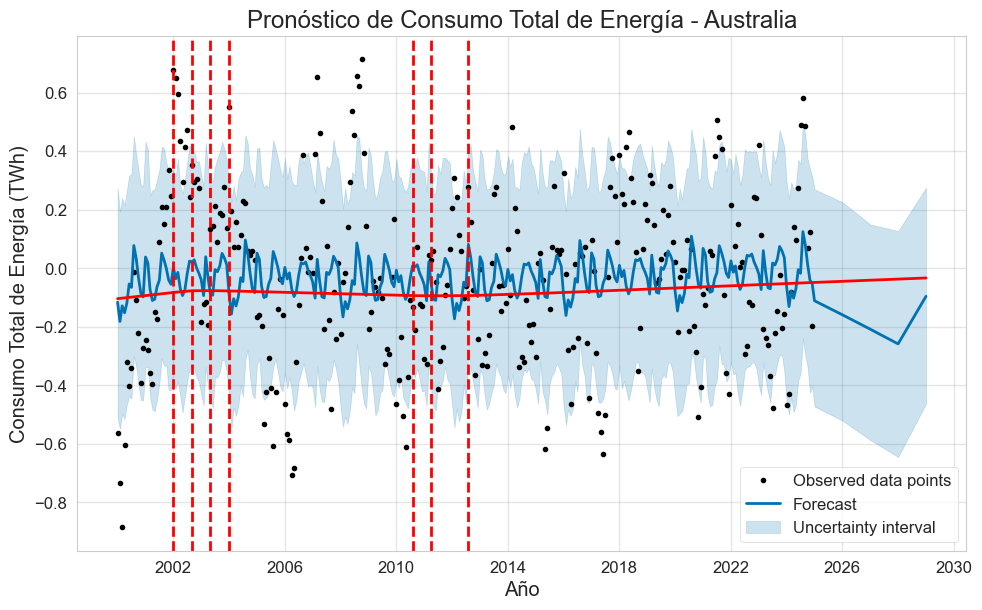

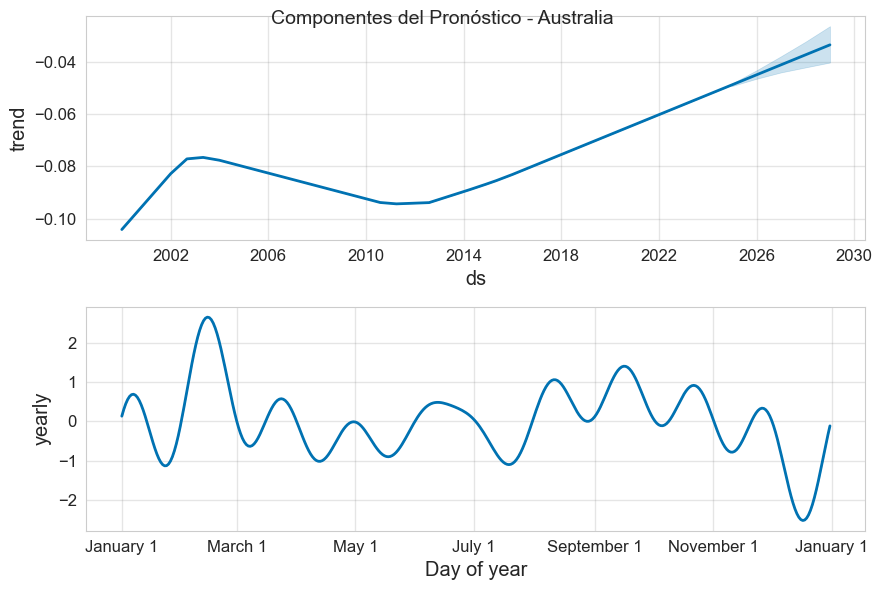

23:44:34 - cmdstanpy - INFO - Chain [1] start processing
23:44:34 - cmdstanpy - INFO - Chain [1] done processing


Entrenando Prophet para Brazil...


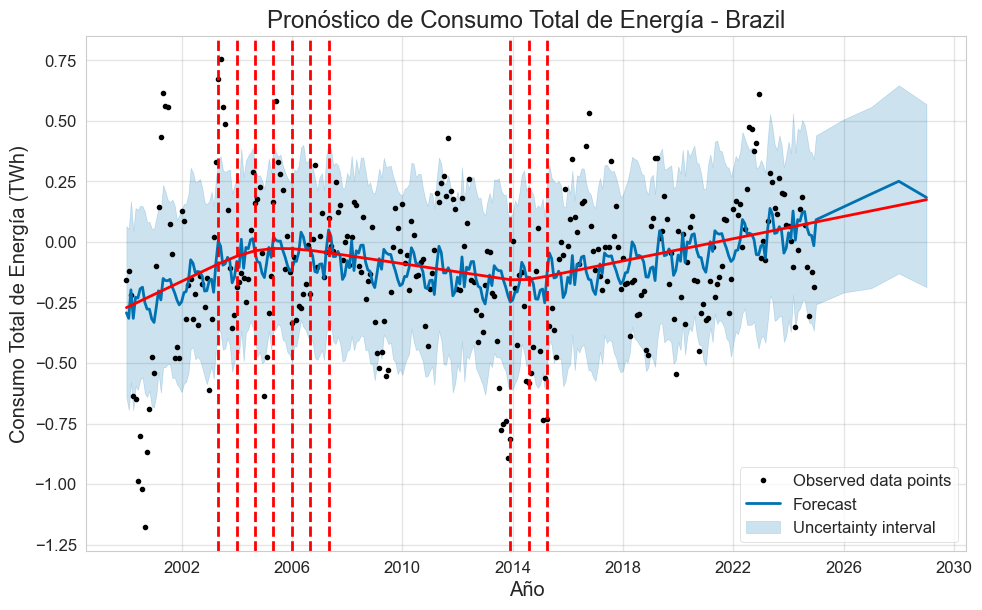

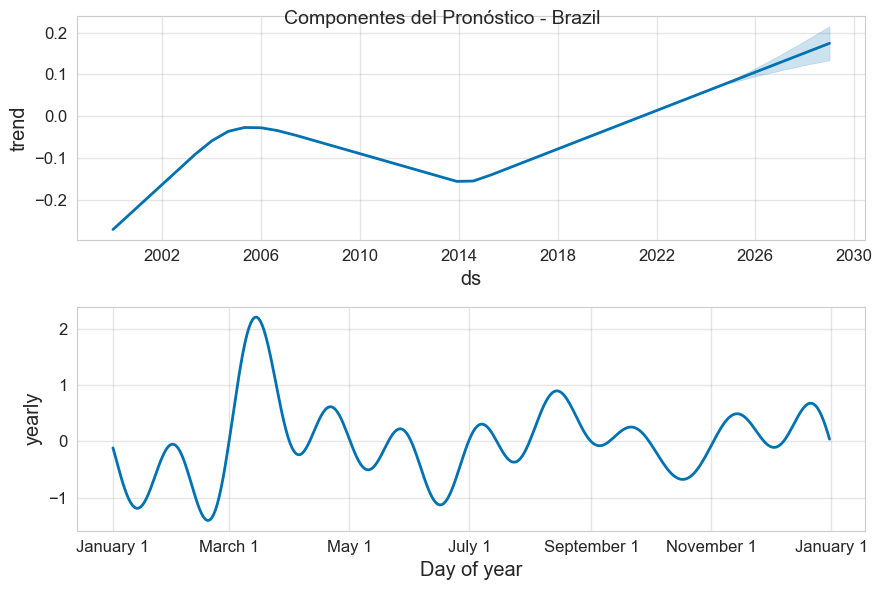

23:44:36 - cmdstanpy - INFO - Chain [1] start processing
23:44:36 - cmdstanpy - INFO - Chain [1] done processing


Entrenando Prophet para Canada...


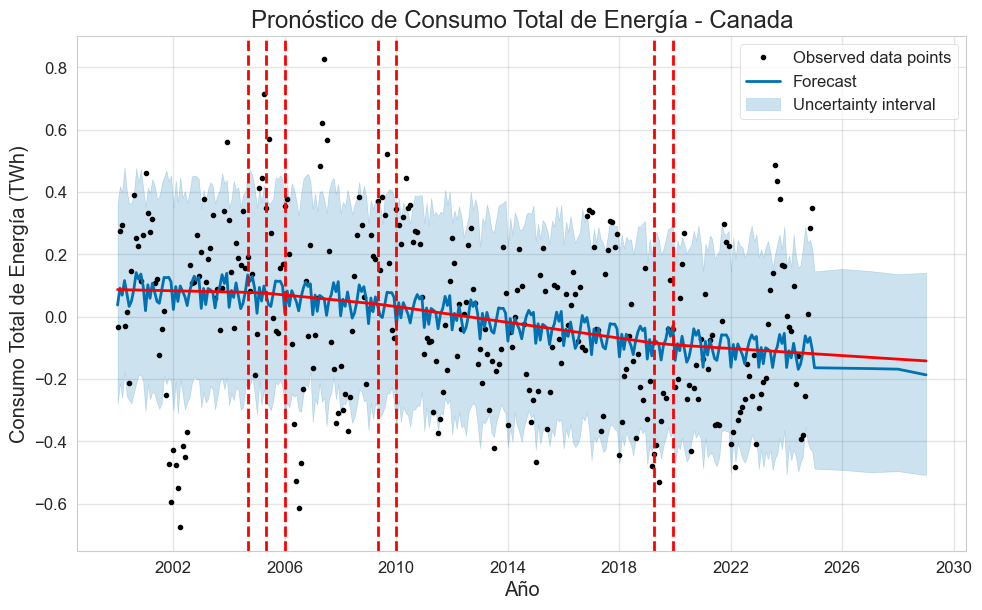

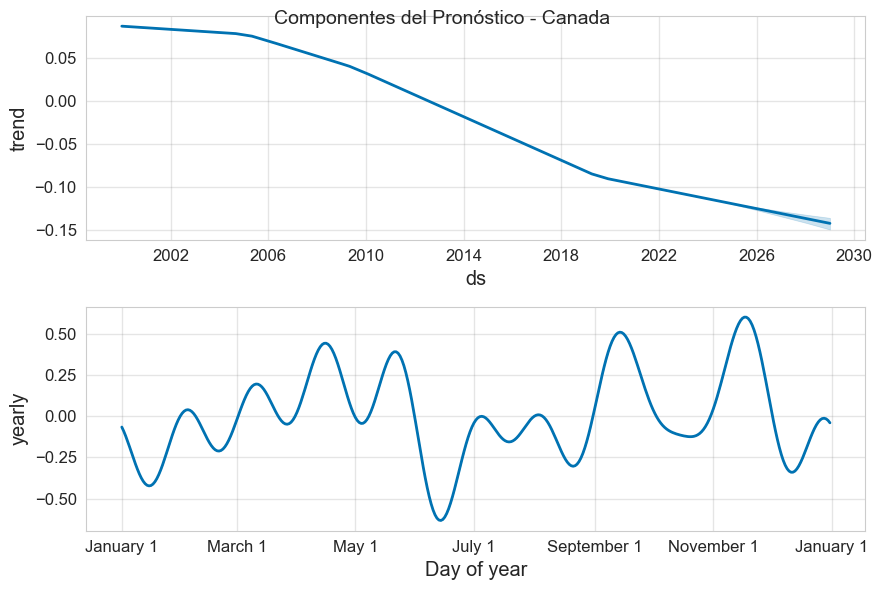

23:44:37 - cmdstanpy - INFO - Chain [1] start processing
23:44:37 - cmdstanpy - INFO - Chain [1] done processing


Entrenando Prophet para China...


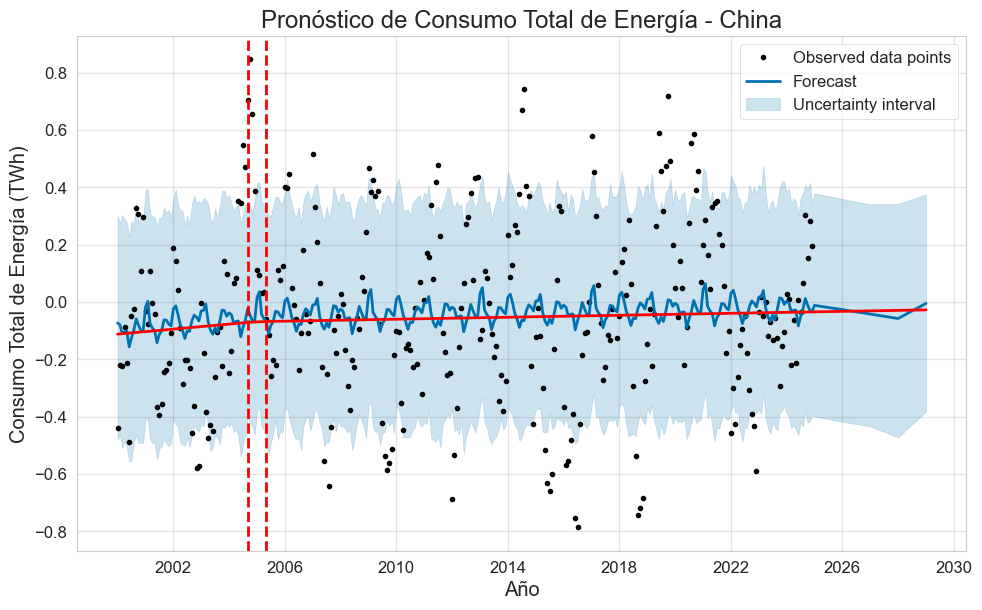

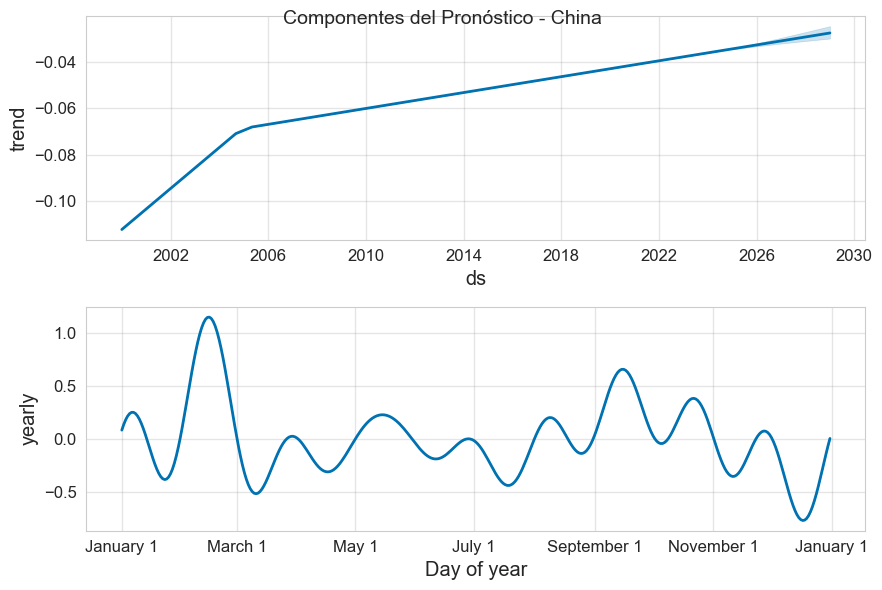

23:44:38 - cmdstanpy - INFO - Chain [1] start processing
23:44:38 - cmdstanpy - INFO - Chain [1] done processing


Entrenando Prophet para Germany...


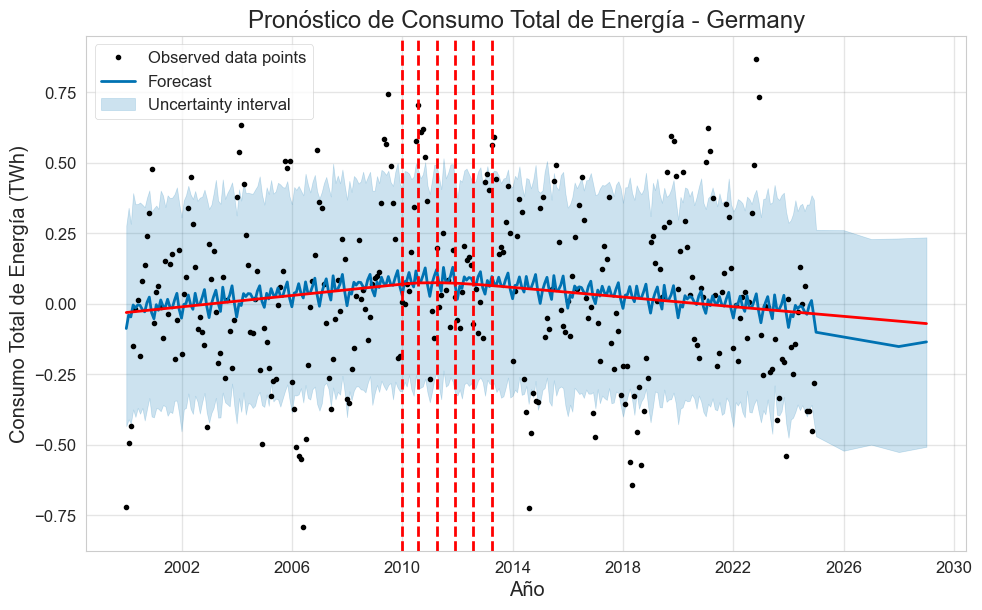

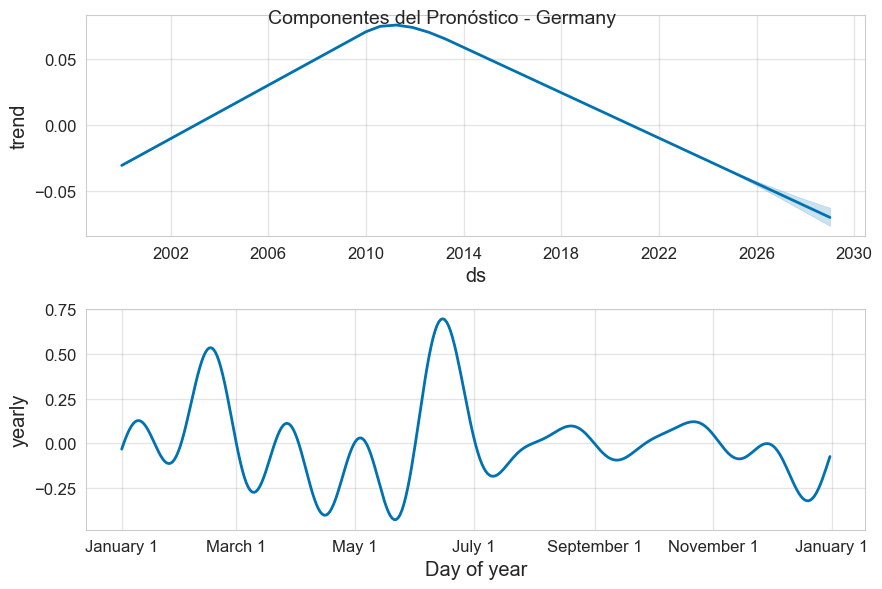

23:44:39 - cmdstanpy - INFO - Chain [1] start processing
23:44:39 - cmdstanpy - INFO - Chain [1] done processing


Entrenando Prophet para India...


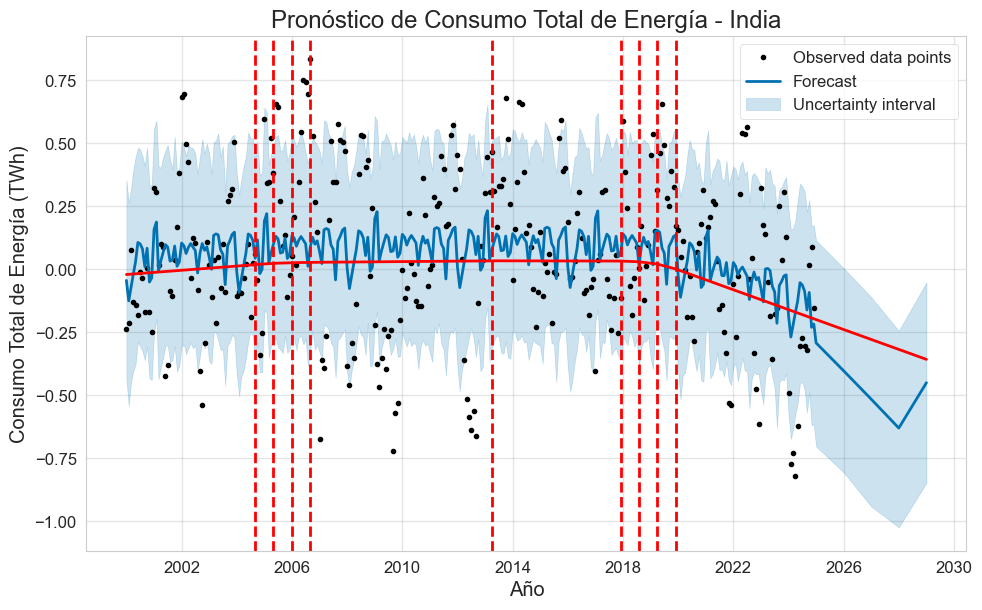

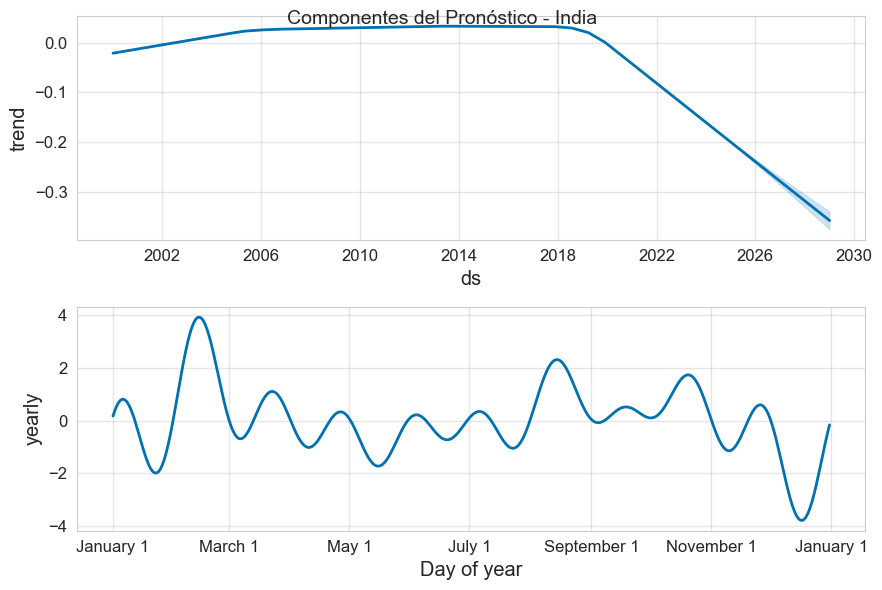

23:44:40 - cmdstanpy - INFO - Chain [1] start processing
23:44:40 - cmdstanpy - INFO - Chain [1] done processing


Entrenando Prophet para Japan...


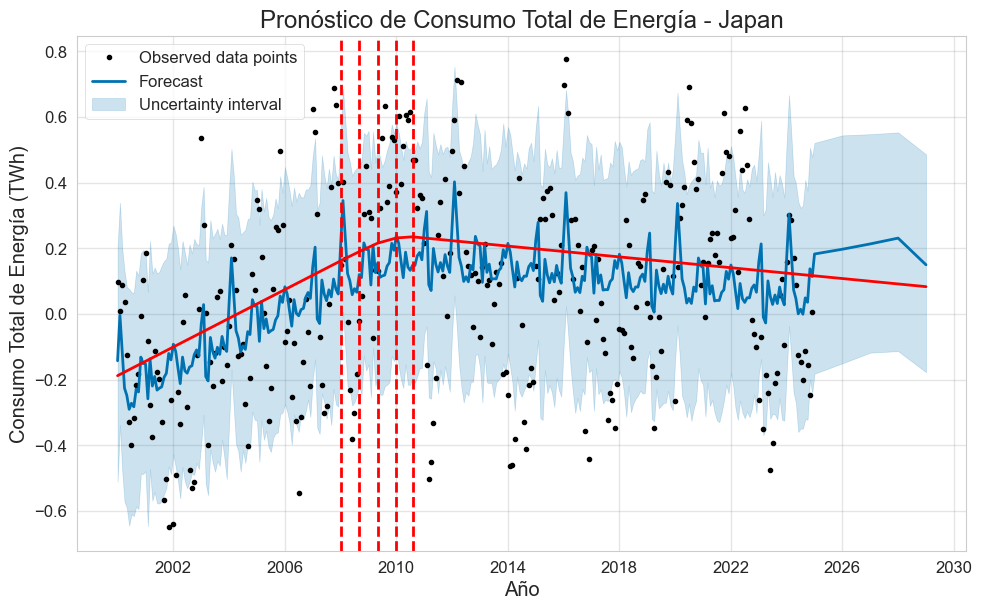

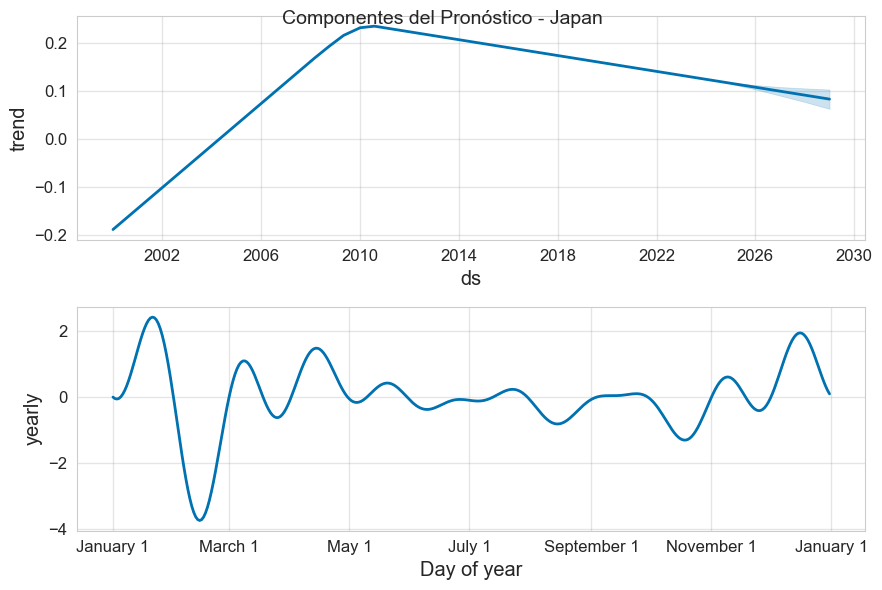

23:44:41 - cmdstanpy - INFO - Chain [1] start processing
23:44:41 - cmdstanpy - INFO - Chain [1] done processing


Entrenando Prophet para Russia...


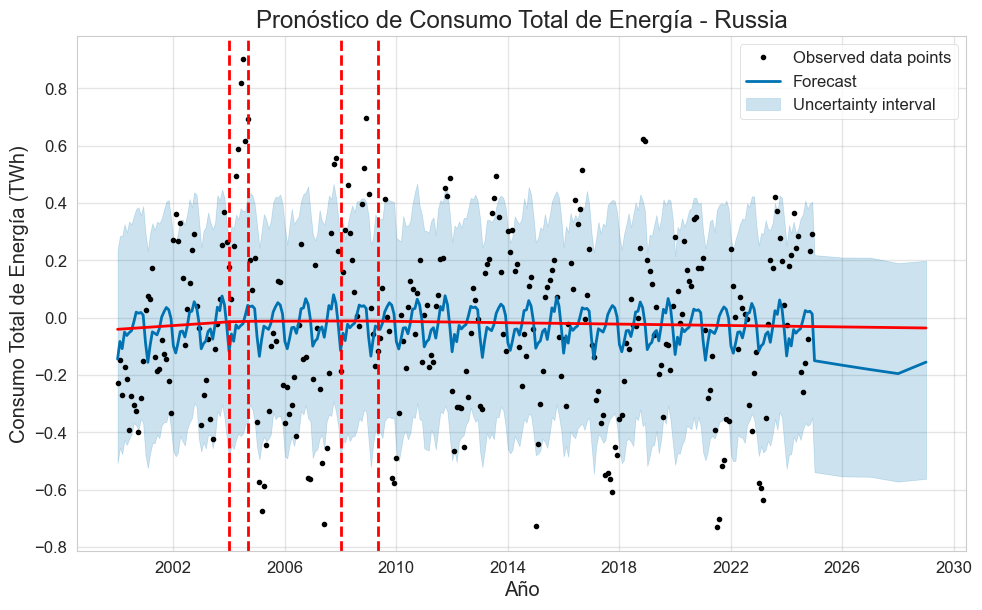

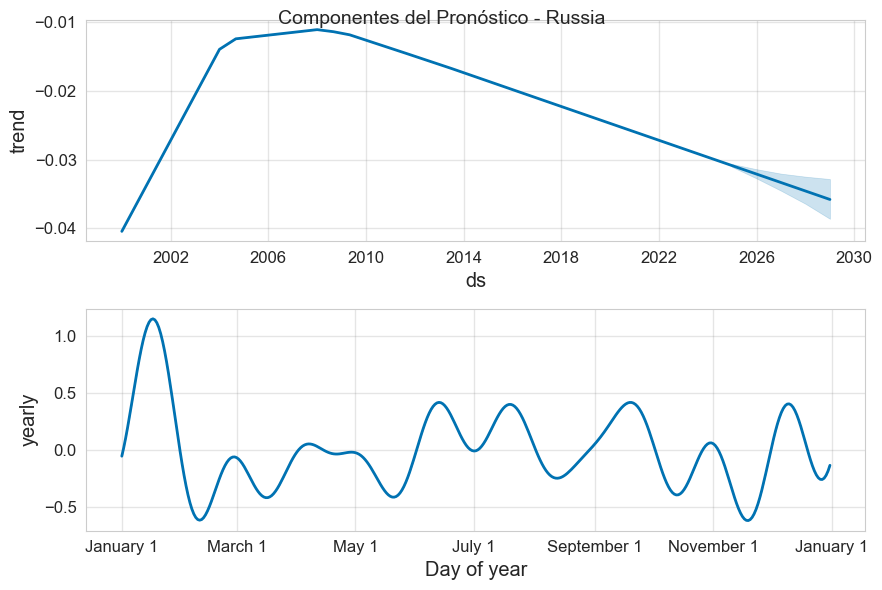

23:44:42 - cmdstanpy - INFO - Chain [1] start processing
23:44:42 - cmdstanpy - INFO - Chain [1] done processing


Entrenando Prophet para UK...


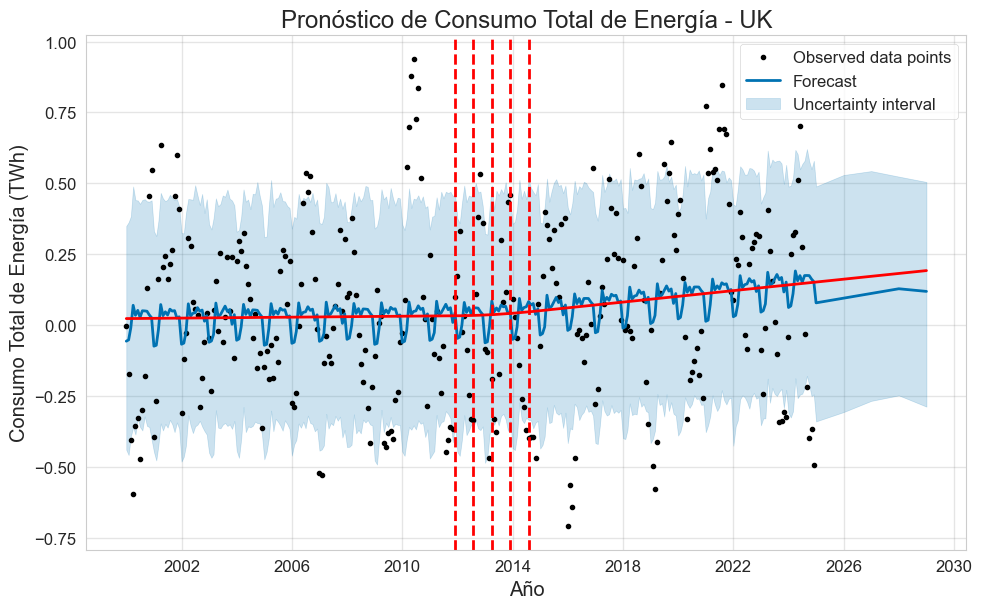

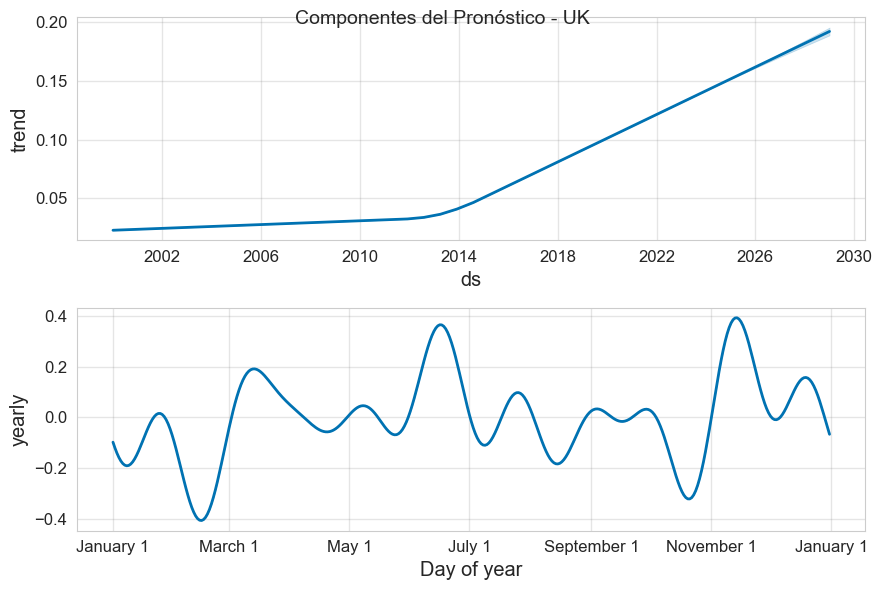

23:44:44 - cmdstanpy - INFO - Chain [1] start processing


Entrenando Prophet para USA...


23:44:44 - cmdstanpy - INFO - Chain [1] done processing


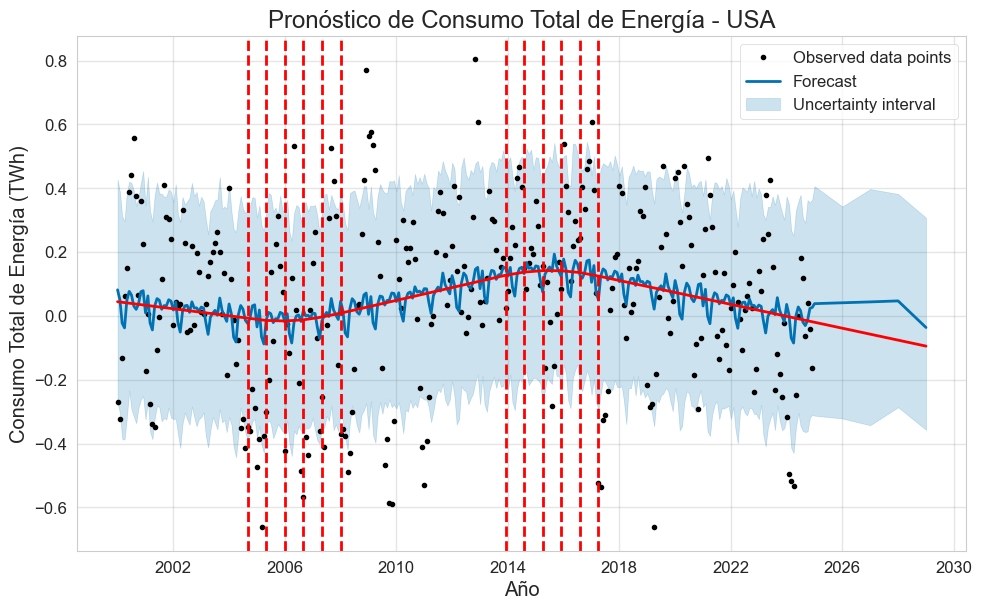

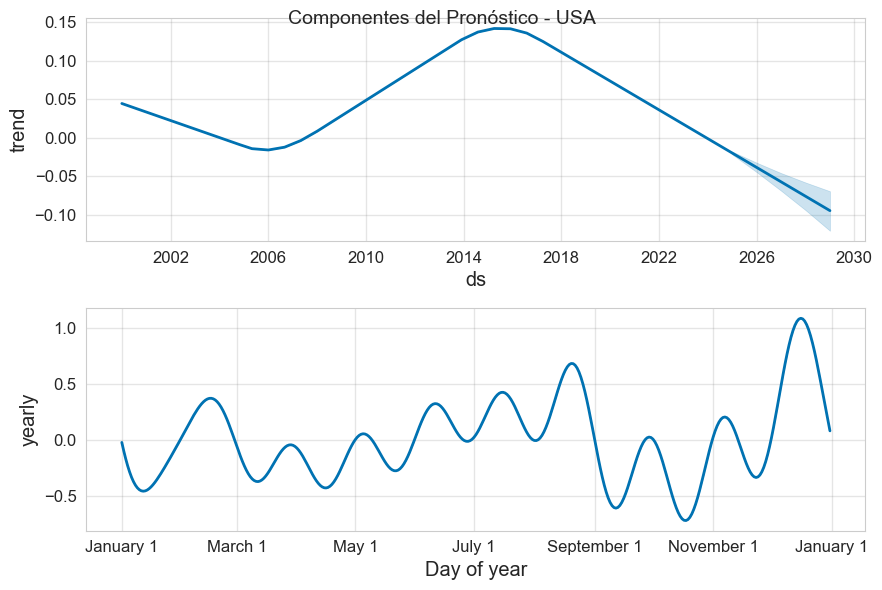

Modelos Prophet entrenados, visualizaciones y archivos .joblib guardados.


In [26]:
prophet_models1, predicciones1 = mod.entrenar_modelos_prophet(df_prophet_total, 'Consumo Total de Energía', '(TWh)', 'total_energy', 5, ruta_salida='../outputs/prophet_forecasts', ruta_modelos='../models/prophet_models')

* Entrenando a Prophet para la variable `Consumo de energía per cápita (kWh)`

23:44:45 - cmdstanpy - INFO - Chain [1] start processing
23:44:45 - cmdstanpy - INFO - Chain [1] done processing


Entrenando Prophet para Australia...


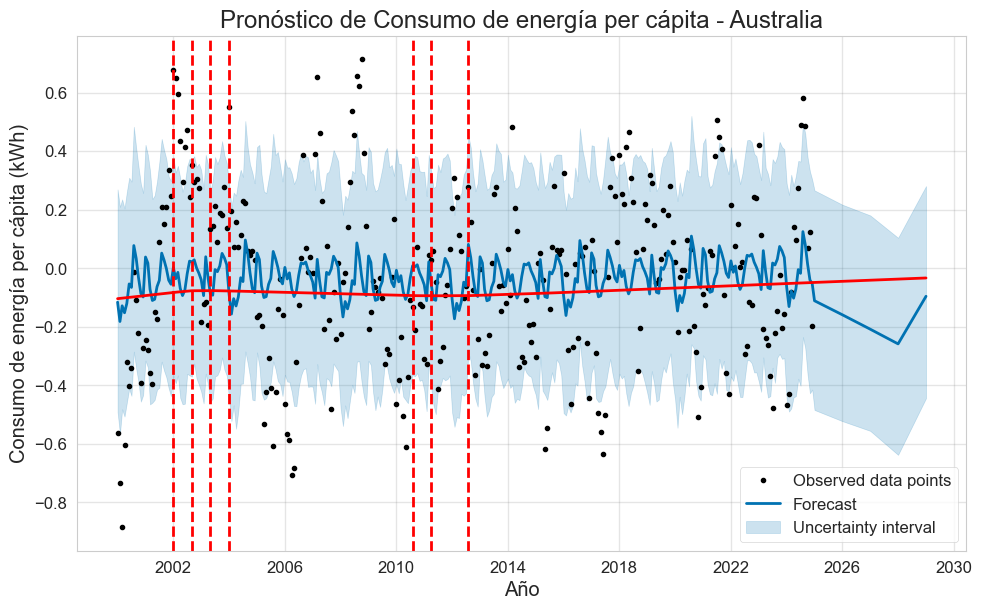

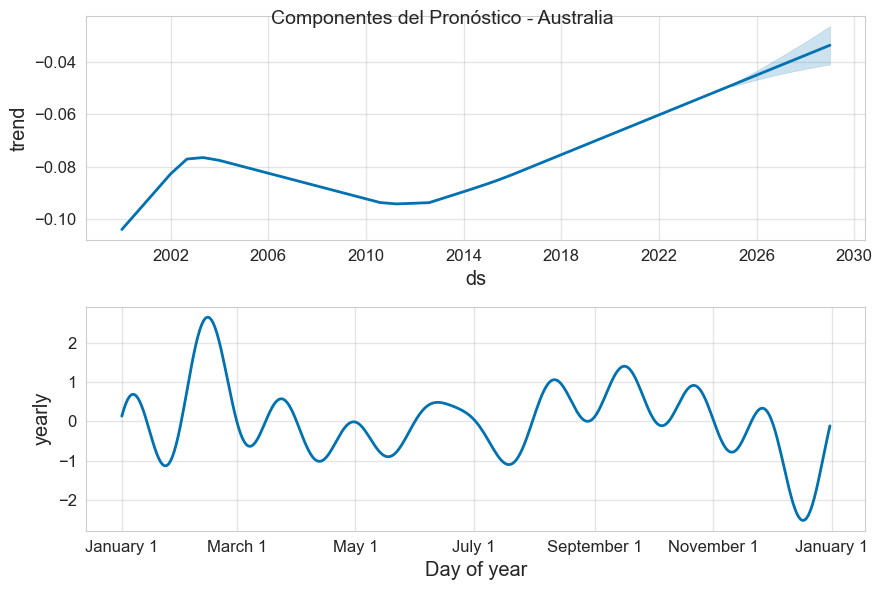

23:44:46 - cmdstanpy - INFO - Chain [1] start processing
23:44:46 - cmdstanpy - INFO - Chain [1] done processing


Entrenando Prophet para Brazil...


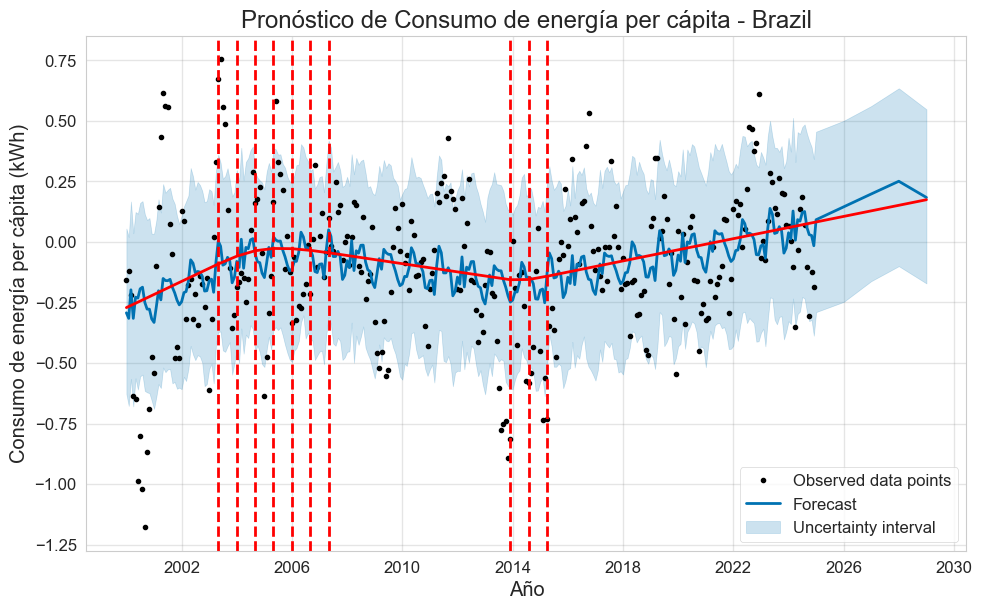

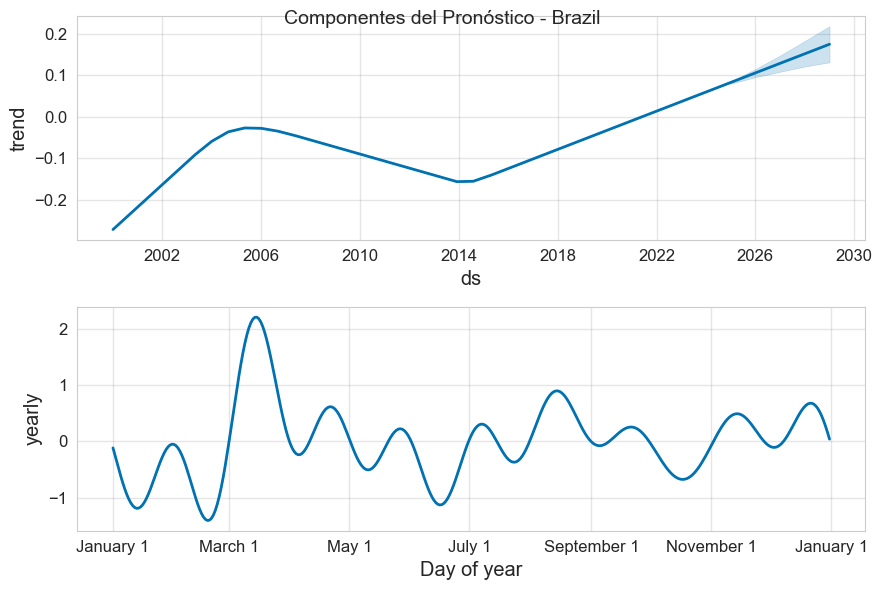

23:44:47 - cmdstanpy - INFO - Chain [1] start processing
23:44:47 - cmdstanpy - INFO - Chain [1] done processing


Entrenando Prophet para Canada...


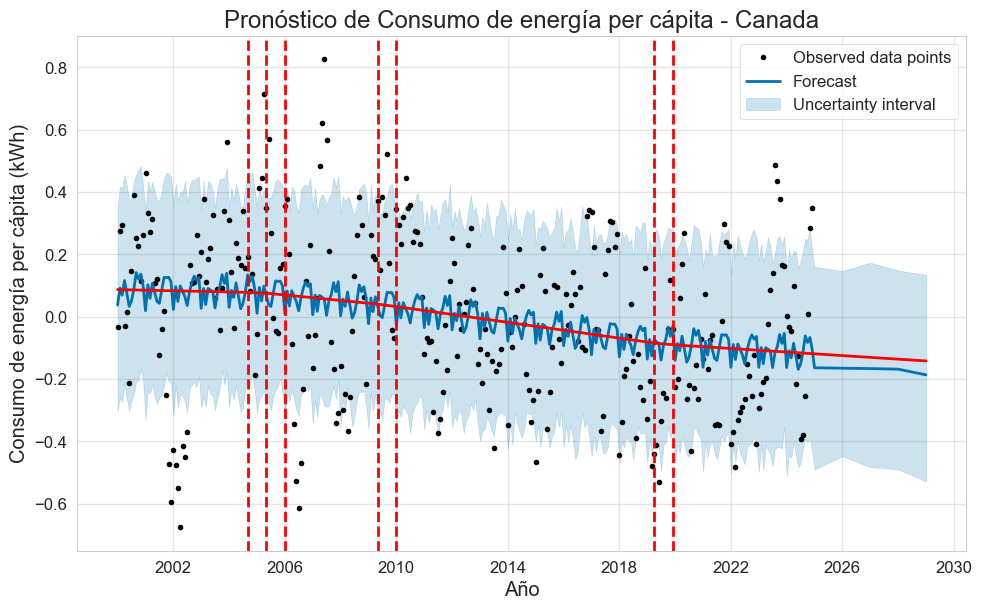

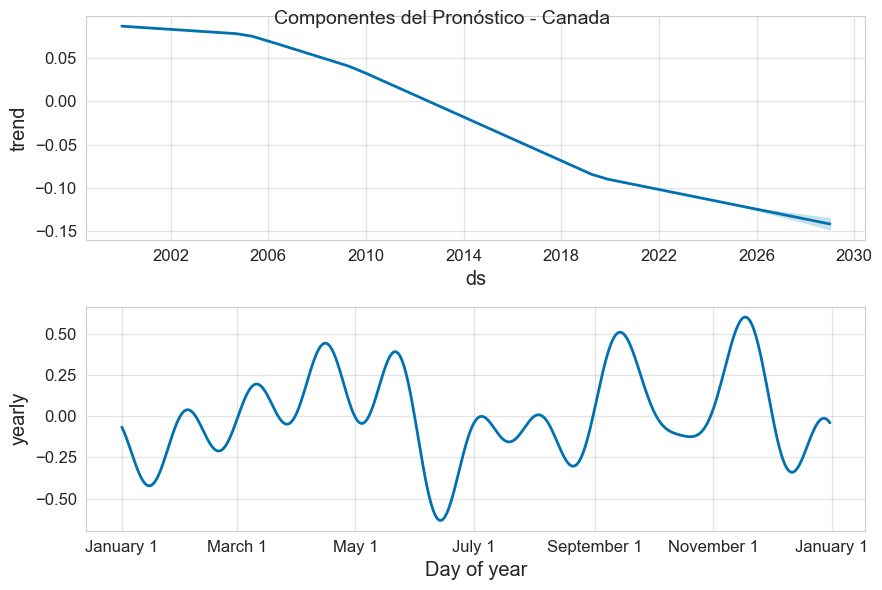

23:44:48 - cmdstanpy - INFO - Chain [1] start processing
23:44:48 - cmdstanpy - INFO - Chain [1] done processing


Entrenando Prophet para China...


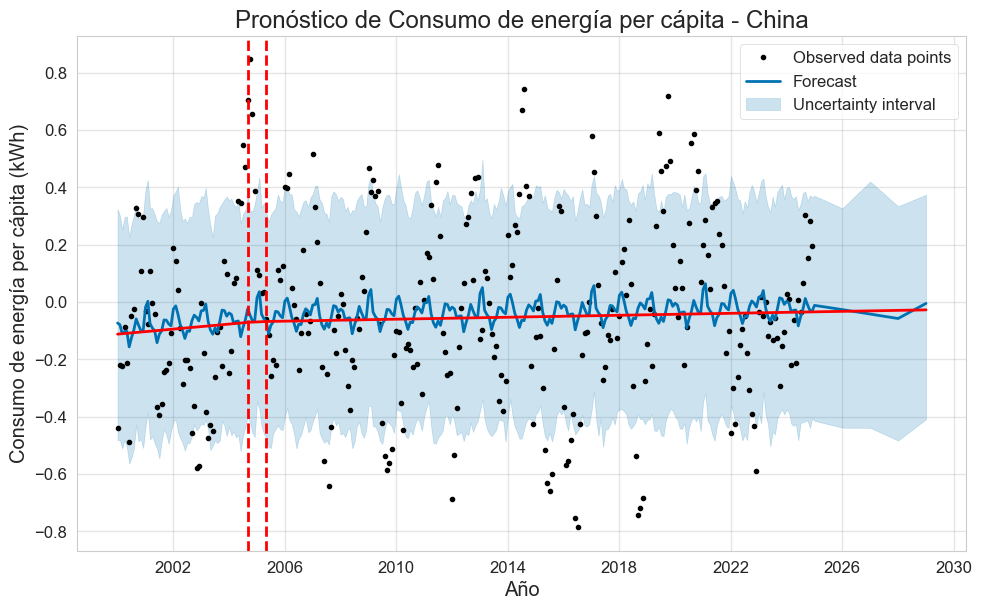

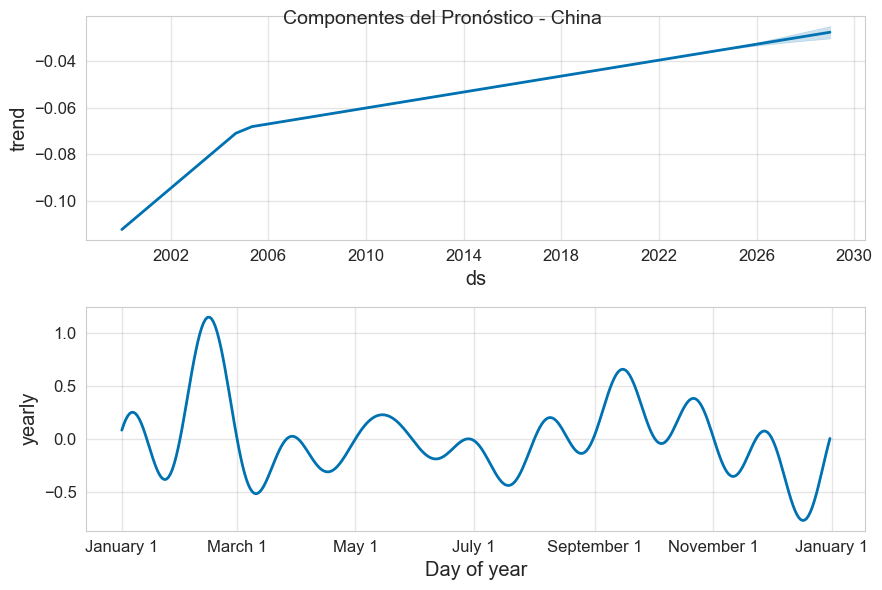

23:44:49 - cmdstanpy - INFO - Chain [1] start processing
23:44:50 - cmdstanpy - INFO - Chain [1] done processing


Entrenando Prophet para Germany...


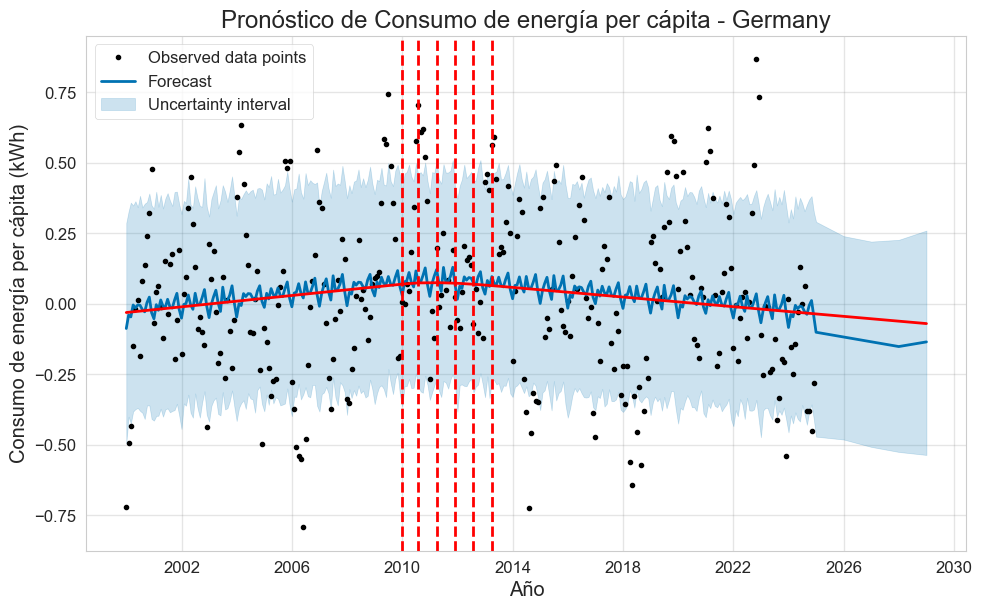

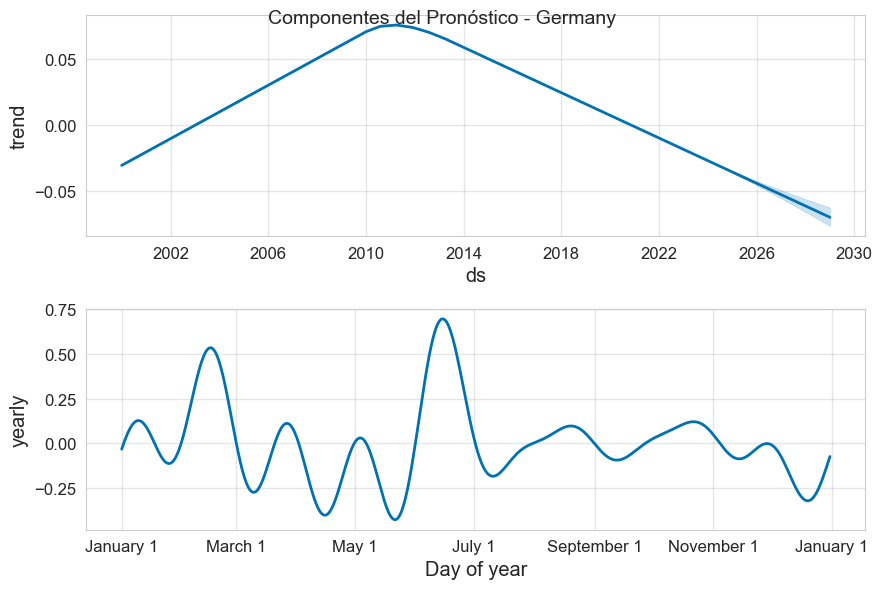

23:44:51 - cmdstanpy - INFO - Chain [1] start processing


Entrenando Prophet para India...


23:44:51 - cmdstanpy - INFO - Chain [1] done processing


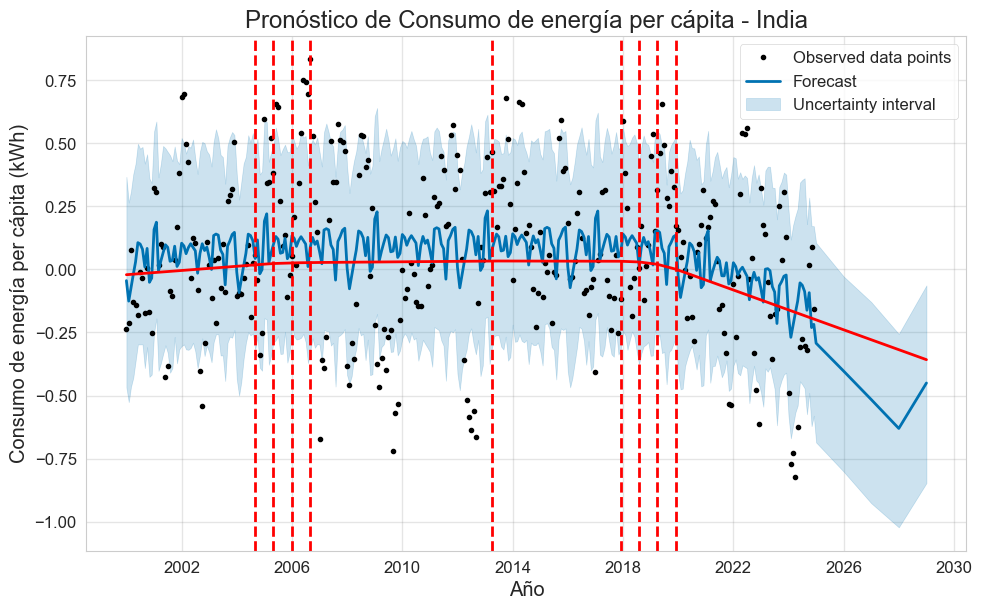

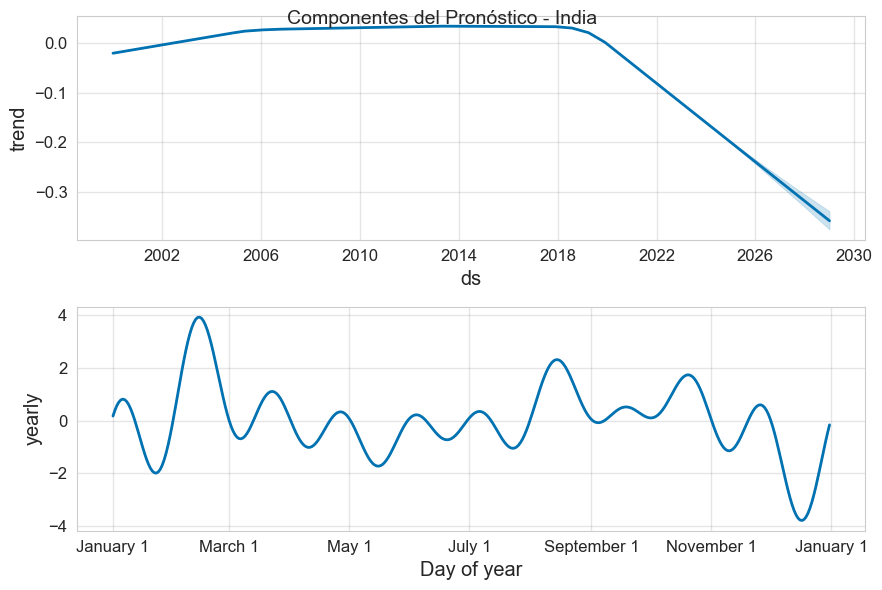

23:44:52 - cmdstanpy - INFO - Chain [1] start processing
23:44:52 - cmdstanpy - INFO - Chain [1] done processing


Entrenando Prophet para Japan...


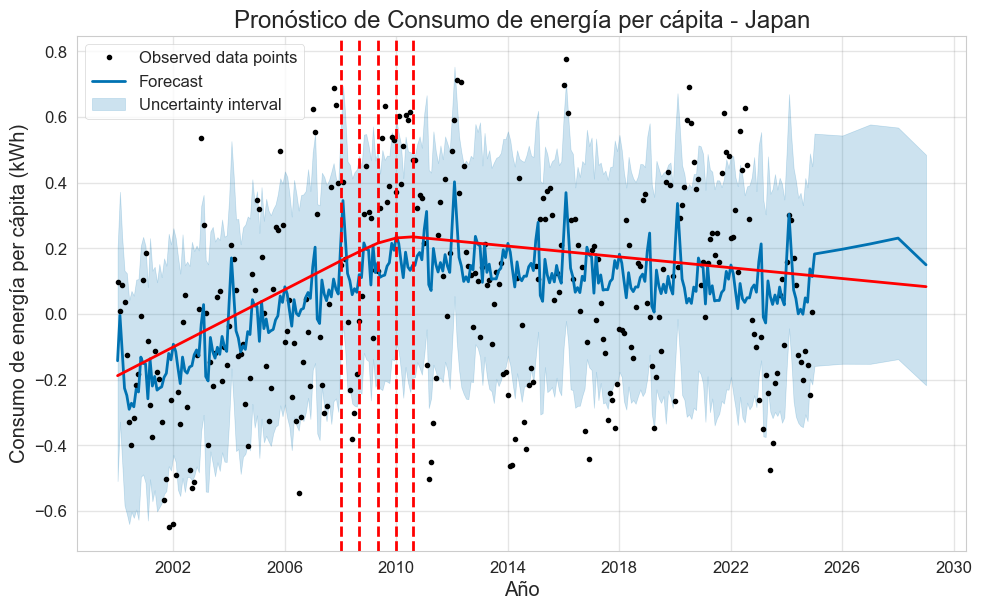

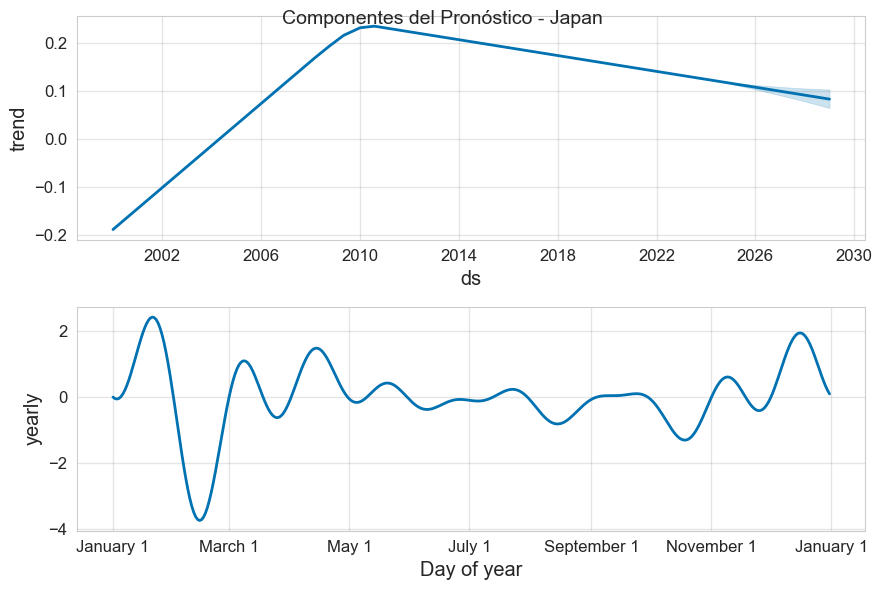

23:44:53 - cmdstanpy - INFO - Chain [1] start processing


Entrenando Prophet para Russia...


23:44:53 - cmdstanpy - INFO - Chain [1] done processing


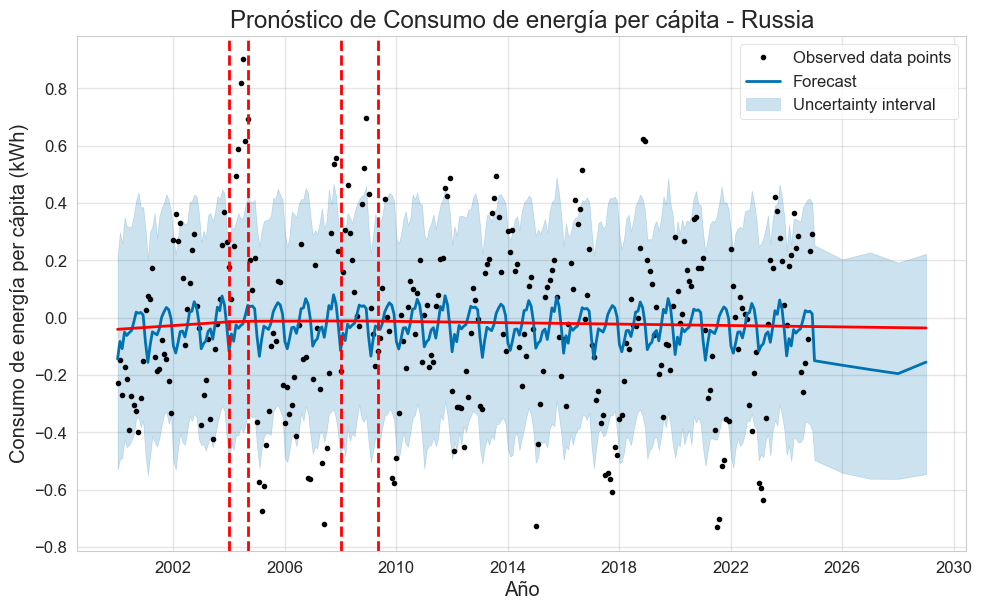

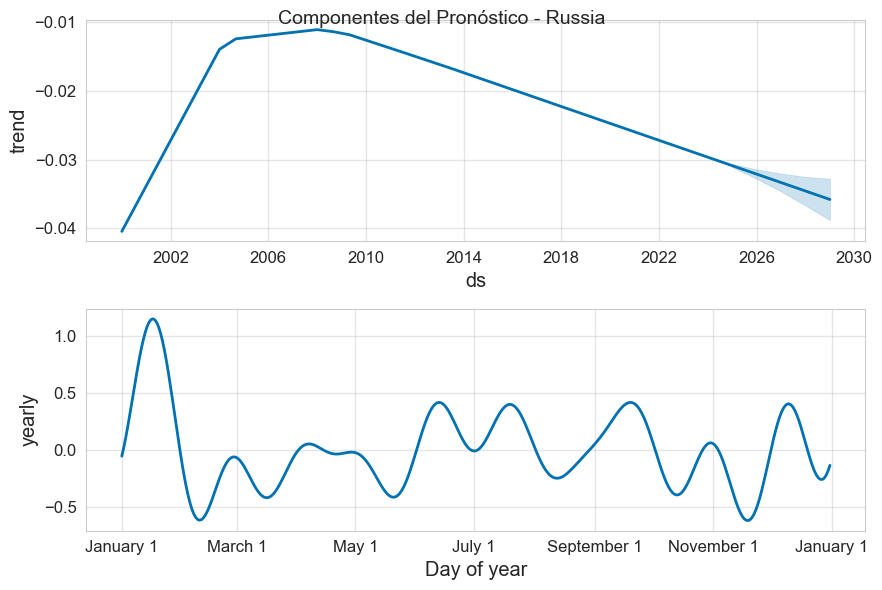

23:44:54 - cmdstanpy - INFO - Chain [1] start processing
23:44:54 - cmdstanpy - INFO - Chain [1] done processing


Entrenando Prophet para UK...


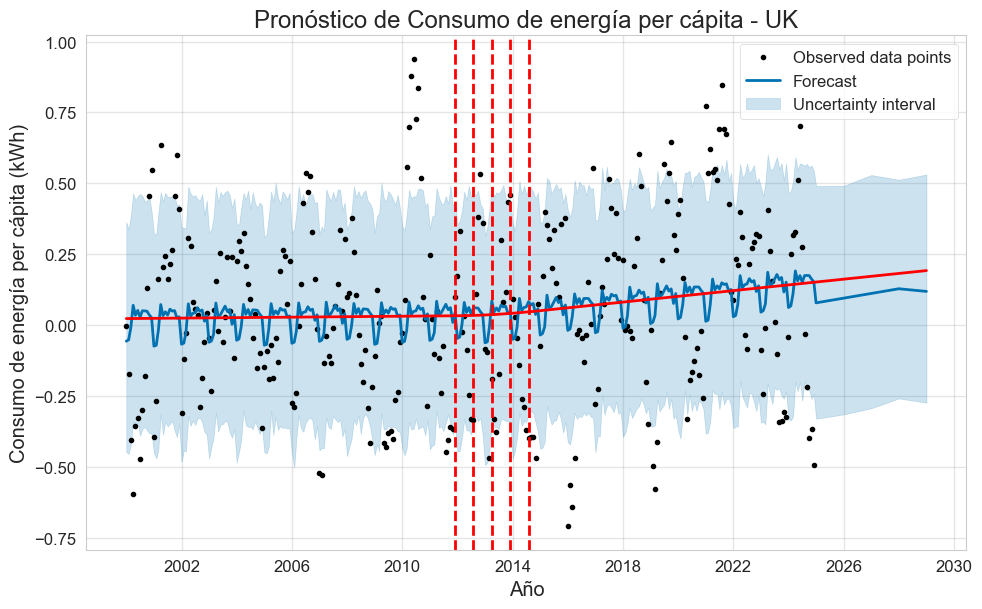

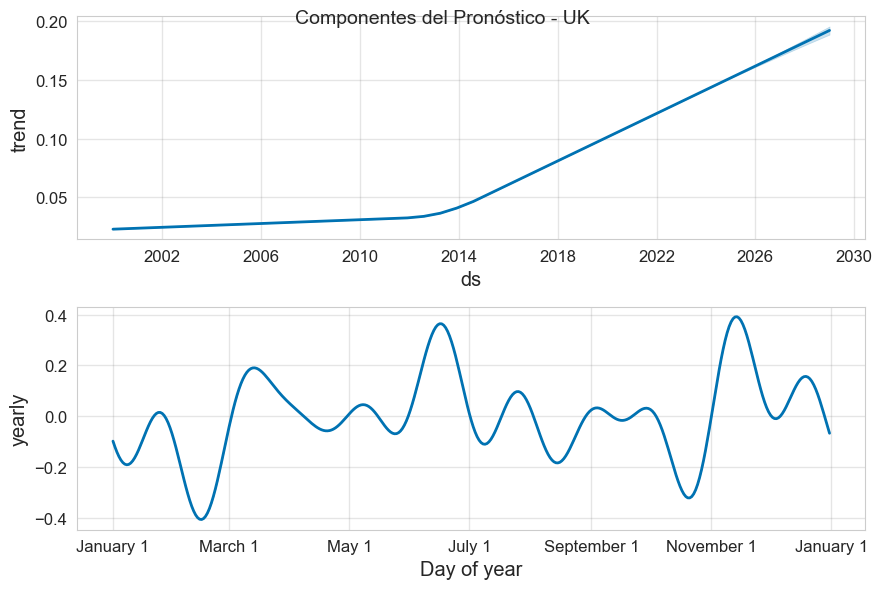

23:44:55 - cmdstanpy - INFO - Chain [1] start processing
23:44:55 - cmdstanpy - INFO - Chain [1] done processing


Entrenando Prophet para USA...


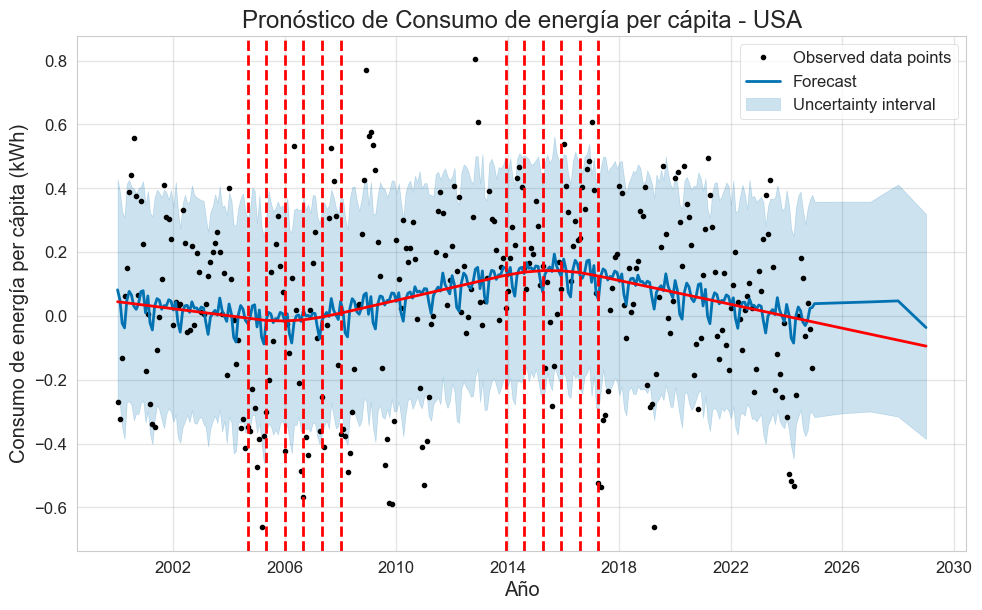

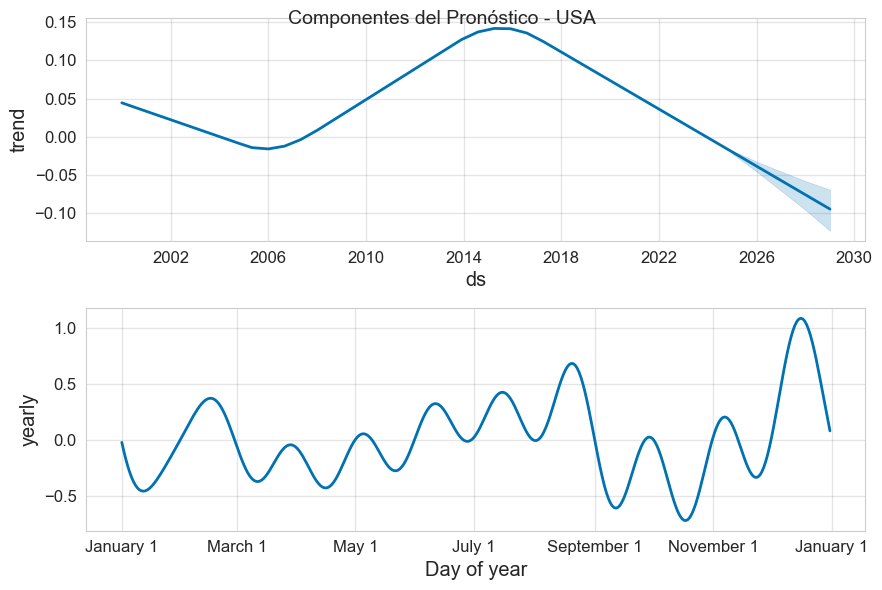

Modelos Prophet entrenados, visualizaciones y archivos .joblib guardados.


In [27]:
prophet_models2, predicciones2 = mod.entrenar_modelos_prophet(df_prophet_total, 'Consumo de energía per cápita', '(kWh)', 'energy_per_cap', 5, ruta_salida='../outputs/prophet_forecasts', ruta_modelos='../models/prophet_models')

### 3.2. Modelo de Regresión: XGBoost

* Entrenamiento y Optimización para Regresión

Se pretende entrenar un modelo de regresión XGBoost para predecir el valor de las emisiones de CO2 en función de las caracteristicas del consumo energético.

Cargando modelo previamente entrenado...
Evaluación del modelo:
   - MSE en Test: 0.12
   - R² en Test: -0.08
Parámetros óptimos encontrados:
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.7, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.05, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 12, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 200, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_me

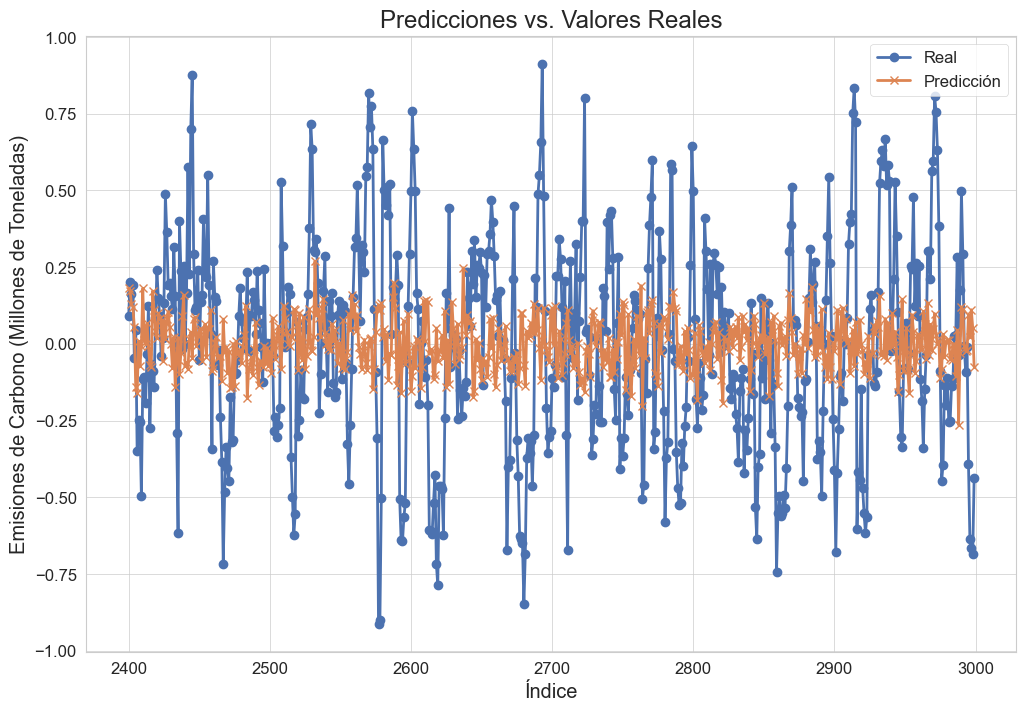

In [28]:
modelo = mod.entrenar_modelo_xgboost_regresion(X_train_reg, y_train_reg, X_test_reg, y_test_reg)

### 3.3. Modelo de Clasificación Random Forest Classifier

* Entrenamiento y Optimización para Clasificación (RandomForestClassifier)

Entrenando modelo base RandomForestClassifier...
Accuracy Base: 0.56
Precision Base: 0.36
Recall Base: 0.30
F1-Score Base: 0.33
ROC AUC Base: 0.50
Modelo guardado en: ../models/initial_random_forest_classifier.joblib


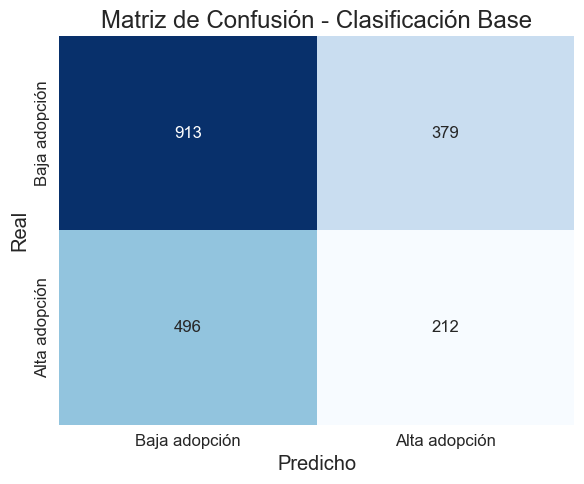

In [29]:
modelo_cls = mod.entrenar_modelo_clasificacion_base(X_train_cls, y_train_cls, X_test_cls, y_test_cls)


Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Mejores parámetros encontrados: {'criterion': 'entropy', 'max_depth': 11, 'min_samples_split': 8, 'n_estimators': 120}
Mejor ROC AUC en validación cruzada: 0.50

Evaluación en el conjunto de prueba:
  - Accuracy:  0.57
  - Precision: 0.37
  - Recall:    0.32
  - F1-Score:  0.34
  - ROC AUC:   0.50

Modelo optimizado guardado en: ../models/best_random_forest_classifier.joblib


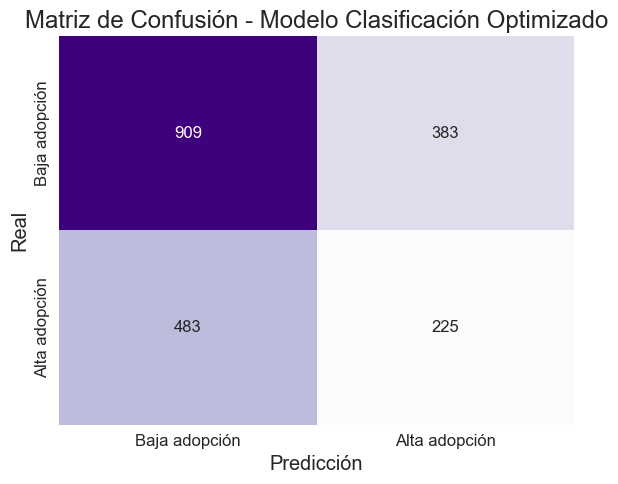

In [30]:
modelo_cls_tuned = mod.entrenar_modelo_clasificacion_tuned(X_train_cls, y_train_cls, X_test_cls, y_test_cls)

# Conclusiones

Durante el desarrollo de este notebook se exploraron distintos enfoques de modelado con el fin de predecir y clasificar patrones energéticos a partir de un conjunto de datos global. Se implementaron y evaluaron tres tipos principales de modelos:

* Predicción de series temporales con Prophet.

* Regresión de emisiones de carbono con RandomForest y XGBRegressor.

* Clasificación de países con alta adopción de energías renovables mediante RandomForestClassifier.

**Predicción de series temporales (Prophet):** El modelo Prophet permitió realizar predicciones rápidas y de bajo costo computacional, siendo útil para visualizar tendencias generales. Sin embargo, su desempeño se vio limitado por la alta variabilidad en el consumo energético (tanto total como per cápita), lo que dificultó la identificación de patrones estacionales consistentes. A pesar de ello, la visualización de los changepoints fue útil para detectar posibles puntos de inflexión en el comportamiento histórico de algunos países, el caso más representativo de esto es Alemani ya que para el año 2009 se observa un cambio significativo en la tendencia del consumo energético per cápita y en el consumo total justo para la epoca de la crisis financiera.

**Regresión de emisiones de carbono:** El modelo de regresión demostró un buen desempeño al predecir valores dentro del rango más frecuente (entre -0.5 y 0.5), lo que indica que es capaz de capturar con precisión las tendencias generales del comportamiento de las emisiones de carbono. Sin embargo, al enfrentarse a valores más extremos, el modelo tiende a subestimarlos, lo que sugiere una sensibilidad limitada frente a variaciones atípicas o casos poco frecuentes.

Esta limitación puede deberse a la presencia de outliers en las variables derivadas utilizadas como predictores. Para mejorar este comportamiento, sería conveniente aplicar técnicas de transformación de variables, como escalados más robustos o ajustes que reduzcan el impacto de los valores extremos. También podría explorarse un ajuste más fino de los hiperparámetros del modelo o considerar modelos adicionales que se especialicen en la detección de comportamientos extremos.

En conjunto, el modelo proporciona una base confiable para análisis generales, pero aún tiene margen de mejora si se desea una mayor precisión en escenarios de alta variabilidad.

**Clasificación de alta adopción de energías renovables:** Los modelos de clasificación, tanto en su versión base como en la optimizada, ofrecieron un rendimiento aceptable al predecir si un país presenta una alta adopción de energías renovables. Al aplicar una optimización de hiperparámetros mediante GridSearchCV, se logró una mejora evidente en los resultados, reflejada en métricas clave como el F1-Score y el área bajo la curva ROC (ROC AUC). Estas métricas indican que el modelo se volvió más equilibrado, al lograr una mejor relación entre la capacidad para identificar correctamente los casos positivos y evitar clasificaciones incorrectas.

Sin embargo, el modelo aún presenta una cantidad significativa de falsos negativos, es decir, países que efectivamente tienen una alta adopción de energías renovables pero que el modelo clasifica como si no la tuvieran. Esto es especialmente importante en contextos de políticas públicas o planificación energética, donde no identificar correctamente estos casos puede llevar a conclusiones erróneas.

Este comportamiento sugiere que, aunque el modelo mejoró con el ajuste, todavía enfrenta dificultades al manejar el desbalance entre clases. Para abordar esta limitación, podrían explorarse otras estrategias como técnicas de sobremuestreo (como SMOTE), el uso de algoritmos aún más sensibles al desbalance o incluso la incorporación de nuevas variables que aporten información más relevante para la clasificación.
